# Topic-Modeling-with-Gensim

Welcome to a new NLP project!

In this project, we are going to use Gensim framework to cover topic modeling. 
- Topic models have been designed specifically for the purpose of extracting
various distinguishing concepts or topics from a large corpus that has various types of documents and each document talks about one or more concepts. The main aim of topic modeling is to use mathematical and statistical techniques to discover hidden and latent semantic structures in a corpus.
- Topic modeling involves extracting features from document terms and using mathematical structures and frameworks like matrix factorization and SVD to generate clusters or groups of terms that are distinguishable from each other and these cluster of words form topics or concepts. These concepts can be used to interpret the main themes of a corpus and make semantic connections among words that co-occur frequently in various documents.

We build some topic models using the following methods:
- Latent Semantic Indexing (LSI)
- Latent Dirichlet Allocation (LDA) - Default
- LDA with MALLET

## Set up the working directory & Import packages ##

In [1]:
# Move to the working directory on Google Drive as using Google Colab
import os
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  PROJECT_ROOT ="/content/drive/MyDrive/GitHub/NLP-Topic-Modeling"
else:
  PROJECT_ROOT ="."
os.chdir(PROJECT_ROOT)
!pwd

Running on CoLab
/content/drive/MyDrive/GitHub/NLP-Topic-Modeling


In [2]:
# Get the running time of each cell 
#  (similar to the ExecuteTime extension for Jupyter Notebook
!pip install ipython-autotime
%load_ext autotime

time: 115 µs (started: 2021-09-20 19:07:25 +00:00)


In [3]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
from tqdm import tqdm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
time: 2.43 s (started: 2021-09-20 19:07:25 +00:00)


In [4]:
# download MALLET
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -q mallet-2.0.8.zip

--2021-09-20 19:07:27--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.4MB/s    in 1.2s    

2021-09-20 19:07:29 (12.4 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

time: 26.4 s (started: 2021-09-20 19:07:27 +00:00)


In [5]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

time: 6.78 ms (started: 2021-09-20 19:07:53 +00:00)


## Load and View Dataset

We're loading all the research papers into `papers` list. Each paper is in its own text file.

In [6]:
DATA_PATH = 'datasets/nipstxt/'
print(os.listdir(DATA_PATH))

folders = ["nips{0:02}".format(i) for i in range(0,13)] # Read all texts into a list.
papers = []
for folder in folders:
  file_names = os.listdir(DATA_PATH + folder) 
  for file_name in file_names:
    with open(DATA_PATH + folder + '/' + file_name, 
              encoding='utf-8', errors='ignore', mode='r+') as f:
      data = f.read() 
      papers.append(data)
len(papers)

['README_yann', 'nips08', 'nips04', 'nips06', 'nips12', 'nips05', 'nips11', 'nips09', 'nips07', 'nips03', 'nips02', 'nips00', 'nips01', 'nips10', 'idx', 'orig', 'MATLAB_NOTES', 'RAW_DATA_NOTES']


1740

time: 14min 1s (started: 2021-09-20 19:07:53 +00:00)


There are a total of 1,740 research papers, which is not a small number! Let’s take a look at a fragment of text from one of the research papers to get an idea.

In [7]:
print(papers[0][:1000])

1 
CONNECTIVITY VERSUS ENTROPY 
Yaser S. Abu-Mostafa 
California Institute of Technology 
Pasadena, CA 91125 
ABSTRACT 
How does the connectivity of a neural network (number of synapses per 
neuron) relate to the complexity of the problems it can handle (measured by 
the entropy)? Switching theory would suggest no relation at all, since all Boolean 
functions can be implemented using a circuit with very low connectivity (e.g., 
using two-input NAND gates). However, for a network that learns a problem 
from examples using a local learning rule, we prove that the entropy of the 
problem becomes a lower bound for the connectivity of the network. 
INTRODUCTION 
The most distinguishing feature of neural networks is their ability to spon- 
taneously learn the desired function from 'training' samples, i.e., their ability 
to program themselves. Clearly, a given neural network cannot just learn any 
function, there must be some restrictions on which networks can learn which 
functions. One obv

## Basic Text Wrangling
We perform some basic text wrangling or preprocessing before diving into topic modeling. We keep things simple here and perform tokenization, lemmatizing nouns, and removing stopwords and any terms having a single character.

In [8]:
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740
time: 30.4 s (started: 2021-09-20 19:21:55 +00:00)


In [9]:
# viewing a processed paper
print(norm_papers[0][:50])

['connectivity', 'versus', 'entropy', 'yaser', 'abu', 'mostafa', 'california', 'institute', 'technology', 'pasadena', 'ca', 'abstract', 'doe', 'connectivity', 'neural', 'network', 'number', 'synapsis', 'per', 'neuron', 'relate', 'complexity', 'problem', 'handle', 'measured', 'entropy', 'switching', 'theory', 'would', 'suggest', 'relation', 'since', 'boolean', 'function', 'implemented', 'using', 'circuit', 'low', 'connectivity', 'using', 'two', 'input', 'nand', 'gate', 'however', 'network', 'learns', 'problem', 'example', 'using']
time: 1 ms (started: 2021-09-20 19:22:26 +00:00)


## Text Representation with Feature Engineering

### Extract and Generate common bi-gram phrases

Before feature engineering and vectorization, we want to extract some useful bi-grams as phrases for each tokenized research paper and remove some unnecessary terms.

In [10]:
bigram = gensim.models.Phrases(norm_papers, 
                               min_count=20, # all words and bi-grams with the count less than 20 are ignored
                               threshold=20, # threshold for forming the phrases (higher means fewer phrases)
                               delimiter=b'_', 
                               ) 
bigram_model = gensim.models.phrases.Phraser(bigram)
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]
print('Total number of papers:', len(norm_corpus_bigrams))

Total number of papers: 1740
time: 28.6 s (started: 2021-09-20 19:22:26 +00:00)


In [11]:
# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '0a'), (1, '2h'), (2, '2h2'), (3, '2he'), (4, '2n'), (5, '__c'), (6, '_c'), (7, '_k'), (8, 'a2'), (9, 'ability'), (10, 'abu_mostafa'), (11, 'access'), (12, 'accommodate'), (13, 'according'), (14, 'accumulated')]
Total Vocabulary Size: 78892
time: 2.16 s (started: 2021-09-20 19:22:55 +00:00)


Looks like we have a lot of unique phrases in our corpus of research papers, based on the preceding output. Several of these terms are not very useful since they are specific to a paper or even a paragraph in a research paper. Hence, it is time to prune
our vocabulary and start removing terms. Leveraging document frequency is a great way to achieve this. By now, you probably realize that the document frequency of a term is basically the total number of times that term occurs across all the documents in a corpus.

In [12]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756
time: 146 ms (started: 2021-09-20 19:22:57 +00:00)


### Feature Engineering with Bag of Word

In [13]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print('Total number of papers:', len(bow_corpus))


# viewing first 50 terms in the first paper and their counts
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])


Total number of papers: 1740
[('ability', 2), ('abu_mostafa', 1), ('afosr', 1), ('air_force', 1), ('american_institute', 1), ('appendix', 1), ('assume', 1), ('asymptotic', 1), ('axe', 1), ('become', 2), ('becomes', 1), ('bt', 1), ('ca_abstract', 1), ('california_institute', 1), ('cannot', 2), ('complete', 2), ('connected', 7), ('consider', 4), ('corresponding', 3), ('denote', 1), ('ea', 3), ('ed', 2), ('element', 9), ('environment', 1), ('expected', 1), ('expression', 4), ('fact', 4), ('final', 2), ('fixed', 4), ('follows', 3), ('furthermore', 1), ('get', 5), ('go', 3), ('going', 1), ('hand', 3), ('hence', 6), ('implemented', 2), ('independent', 1), ('independently', 1), ('interested', 1), ('ity', 1), ('know', 1), ('le', 1), ('let', 12), ('need', 1), ('neuron', 14), ('next_section', 1), ('occur', 1), ('office_scientific', 1), ('otherwise', 4)]
time: 1.26 s (started: 2021-09-20 19:22:57 +00:00)


## Topic Models with Latent Semantic Indexing (LSI)
- LSI is a statistical technique that has the ability to uncover latent hidden terms that correlate semantically to form topics. The main principle behind LSI is that similar terms tend to be used in the same context and hence tend to co-occur more. 
- LSI uses the very popular Singular Value Decomposition (SVD) technique.
- LSI is not just used for text summarization, but also in information retrieval and search. 

### Build model with Gensim

In [14]:
TOTAL_TOPICS = 10
lsi_bow = gensim.models.LsiModel(bow_corpus, 
                                 id2word=dictionary, 
                                 num_topics=TOTAL_TOPICS,
                                 onepass=True,
                                 chunksize=len(bow_corpus), 
                                 power_iters=1000)

time: 3min 24s (started: 2021-09-20 19:22:58 +00:00)


### View the major topics/themes

In [15]:
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.215*"unit" + 0.212*"state" + 0.187*"training" + 0.177*"neuron" + 0.162*"pattern" + 0.145*"image" + 0.140*"vector" + 0.125*"feature" + 0.122*"cell" + 0.110*"layer" + 0.101*"task" + 0.097*"class" + 0.091*"probability" + 0.089*"signal" + 0.087*"step" + 0.086*"response" + 0.085*"representation" + 0.083*"noise" + 0.082*"rule" + 0.081*"distribution"

Topic #2:
0.487*"neuron" + 0.396*"cell" + -0.257*"state" + 0.191*"response" + -0.187*"training" + 0.170*"stimulus" + 0.117*"activity" + -0.109*"class" + 0.099*"spike" + 0.097*"pattern" + 0.096*"circuit" + 0.096*"synaptic" + -0.095*"vector" + 0.090*"signal" + 0.090*"firing" + 0.088*"visual" + -0.084*"classifier" + -0.083*"action" + -0.078*"word" + 0.078*"cortical"

Topic #3:
-0.627*"state" + 0.395*"image" + -0.219*"neuron" + 0.209*"feature" + -0.188*"action" + 0.137*"unit" + 0.131*"object" + -0.130*"control" + 0.129*"training" + -0.109*"policy" + 0.103*"classifier" + 0.090*"class" + -0.081*"step" + -0.081*"dynamic" + 0.080*"classifica

**Note that**:
- The higher the weight, the more important the contribution.
- The sign on each term indicates a sense of direction or orientation in the vector space for a particular topic. So similar correlated terms have the same sign or direction.

Let’s separate these terms in each topic based on their signs and try to interpret the topics again.

In [16]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('unit', 0.215), ('state', 0.212), ('training', 0.187), ('neuron', 0.177), ('pattern', 0.162), ('image', 0.145), ('vector', 0.14), ('feature', 0.125), ('cell', 0.122), ('layer', 0.11), ('task', 0.101), ('class', 0.097), ('probability', 0.091), ('signal', 0.089), ('step', 0.087), ('response', 0.086), ('representation', 0.085), ('noise', 0.083), ('rule', 0.082), ('distribution', 0.081)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('neuron', 0.487), ('cell', 0.396), ('response', 0.191), ('stimulus', 0.17), ('activity', 0.117), ('spike', 0.099), ('pattern', 0.097), ('circuit', 0.096), ('synaptic', 0.096), ('signal', 0.09), ('firing', 0.09), ('visual', 0.088), ('cortical', 0.078)]
--------------------------------------------------
Direction 2: [('state', -0.257), ('training', -0.187), ('class', -0.109), ('vector', -0.095), ('classifier', -0.084), ('action', -0.083), ('w

Here we can see clear themes of modeling being applied in chips and electronic devices, classification and recognition models, neural models talking about the human brain components like cells, stimuli, neurons, cortical components, and even themes around reinforcement learning! We explore these in detail later in a more structured way.

### View the proportion of each topic per document

In [17]:
# get term-topic matrix, singular values, and a topic-document matrix
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


((7756, 10), (10,), (10, 1740))

time: 300 ms (started: 2021-09-20 19:26:22 +00:00)


In [18]:
# get document-topic matrix
#  that would help us see the proportion of each topic per document 
#  (a larger proportion means the topic is more dominant in the document
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(10)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.016,0.017,-0.013,0.008,-0.024,-0.028,0.000,0.019,0.008,0.006
1,0.022,-0.000,-0.022,0.008,-0.011,-0.016,0.013,0.017,0.001,-0.007
2,0.032,0.036,-0.011,-0.014,-0.035,-0.052,-0.016,0.043,0.010,0.029
3,0.035,-0.002,-0.017,-0.008,-0.016,-0.017,0.032,0.022,-0.050,-0.029
4,0.015,-0.004,0.004,-0.004,-0.017,-0.002,0.003,0.013,-0.025,-0.010
5,0.028,0.038,0.011,0.010,0.016,0.071,-0.001,0.008,-0.004,-0.010
6,0.029,-0.001,0.007,-0.089,0.021,-0.014,0.043,0.021,0.002,0.011
7,0.033,0.080,-0.025,0.016,-0.022,0.003,-0.011,-0.023,-0.004,-0.009
8,0.030,0.046,-0.011,0.026,-0.057,-0.046,-0.017,0.009,0.048,0.017
9,0.029,0.028,-0.010,0.016,-0.031,-0.031,0.005,-0.035,-0.007,-0.000


time: 32.5 ms (started: 2021-09-20 19:26:23 +00:00)


Ignoring the sign, we can try to find out the most important topics for a few sample papers and see if they make sense.

In [19]:
some_document_numbers = [13, 250, 500]

for document_number in some_document_numbers:
    top_3_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('='*50)
    print('- Document #'+str(document_number)+':')
    print('- Dominant Topics (top 3):', top_3_topics)
    print('- Paper first 500 words:')
    print(papers[document_number][:500])
    print()

- Document #13:
- Dominant Topics (top 3): ['T7', 'T1', 'T5']
- Paper first 500 words:
144 
SPEECH RECOGNITION EXPERIMENTS 
WITH PERCEPTRONS 
D. J. Burr 
Bell Communications Research 
Morristown, NJ 07960 
ABSTRACT 
Artificial neural networks (ANNs) are capable of accurate recognition of 
simple speech vocabularies such as isolated digits [1]. This paper looks at two 
more difficult vocabularies, the alphabetic E-set and a set of polysyllabic 
words. The E-set is difficult because it contains weak discriminants and 
polysyllables are difficult because of timing variation. Polysyll

- Document #250:
- Dominant Topics (top 3): ['T10', 'T4', 'T8']
- Paper first 500 words:
642 Chauvin 
Dynamic Behavior of Constrained 
Back-Propagation Networks 
Yves Chauvin 1 
Thomson-CSF, Inc. 
630 Hansen Way, Suite 250 
Palo Alto, CA. 94304 
ABSTRACT 
The learning dynamics of the back-propagation algorithm are in- 
vestigated when complexity constraints are added to the standard 
Least Mean Square (LMS) 

If we look at the description of the terms in each of the selected topics in the preceding output, they make perfect sense.
- Paper #13 has a dominance of topics 6, 1, and 2, which pretty much talk about neurons, cells, brain’s cortex, stimulus, and so on (aspects around neuromorphic networks).
- Paper #250 has a dominance of topics 3, 5, and 8, which talk about object recognition, image classification, and visual representation with neural networks. This matches the paper’s theme, which is about object recognition.
- Paper #500 has a dominance of topics 9, 8, and 10, which talk about signals, voltage, chips, circuits, and so on. This is in line with the theme of the paper around parameter settings for analog circuits.

## Topic Models with Latent Dirichlet Allocation (LDA)

### Build model with Gensim

In [20]:
lda_model = gensim.models.LdaModel(corpus=bow_corpus, 
                                   id2word=dictionary, 
                                   chunksize=len(bow_corpus), 
                                   alpha='auto', 
                                   eta='auto', 
                                   random_state=42,
                                   iterations=500,
                                   num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

time: 1min 35s (started: 2021-09-20 19:26:23 +00:00)


### View the major topics/themes

In [21]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.014*"control" + 0.008*"unit" + 0.007*"state" + 0.007*"trajectory" + 0.006*"target" + 0.006*"dynamic" + 0.006*"movement" + 0.006*"motor" + 0.005*"position" + 0.005*"module" + 0.005*"task" + 0.005*"controller" + 0.005*"representation" + 0.004*"pattern" + 0.004*"change" + 0.004*"subject" + 0.004*"hand" + 0.004*"behavior" + 0.004*"arm" + 0.003*"activation"

Topic #2:
0.012*"chip" + 0.011*"circuit" + 0.008*"image" + 0.007*"current" + 0.007*"neuron" + 0.006*"voltage" + 0.006*"analog" + 0.004*"processor" + 0.004*"signal" + 0.004*"implementation" + 0.004*"bit" + 0.004*"design" + 0.004*"pixel" + 0.004*"line" + 0.003*"vector" + 0.003*"neural" + 0.003*"device" + 0.003*"digital" + 0.003*"application" + 0.003*"architecture"

Topic #3:
0.027*"state" + 0.014*"action" + 0.009*"policy" + 0.008*"control" + 0.007*"step" + 0.007*"reinforcement_learning" + 0.006*"optimal" + 0.005*"task" + 0.005*"environment" + 0.004*"reward" + 0.004*"goal" + 0.004*"agent" + 0.004*"td" + 0.004*"cost" + 0.004*"ro

### Evaluate the model
We can use perplexity and coherence scores as measures to evaluate the topic model. Typically, the model is better when:
- the perplexity is lower 
- the UMass score is lower  
- the Cv score in coherence is higher 

In [22]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.4952768212161648
Avg. Coherence Score (UMass): -1.019023501294632
Model Perplexity: -7.786466460547686
time: 54.6 s (started: 2021-09-20 19:27:58 +00:00)


## LDA Models with MALLET
The MALLET framework is a Java-based package for statistical natural language processing, document classification, clustering, topic modeling, information extraction, and other machine learning applications to text. MALLET stands for MAchine Learning for LanguagE Toolkit. It was developed by Andrew McCallum along with several people at the University of Massachusetts Amherst. The MALLET topic modeling toolkit contains efficient, sampling-based implementations of Latent Dirichlet Allocation, Pachinko Allocation, and Hierarchical LDA.

### Build LDA model using MALLET & Gensim

In [23]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, 
                                              corpus=bow_corpus, 
                                              num_topics=TOTAL_TOPICS, 
                                              id2word=dictionary,
                                              iterations=500, workers=16)

time: 1min 26s (started: 2021-09-20 19:28:53 +00:00)


### View the major topics/themes

In [24]:
topics = [[(term, round(wt, 3)) for term, wt in lda_mallet.show_topic(n, topn=20)] for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):
  print('Topic #'+str(idx+1)+':')
  print([term for term, wt in topic])
  print()

Topic #1:
['distribution', 'estimate', 'variable', 'gaussian', 'probability', 'prior', 'variance', 'mixture', 'density', 'sample', 'approximation', 'estimation', 'prediction', 'bayesian', 'component', 'structure', 'regression', 'likelihood', 'log', 'statistical']

Topic #2:
['image', 'object', 'feature', 'visual', 'map', 'motion', 'region', 'pixel', 'local', 'direction', 'location', 'representation', 'receptive_field', 'orientation', 'view', 'spatial', 'face', 'center', 'field', 'position']

Topic #3:
['state', 'action', 'step', 'control', 'task', 'policy', 'optimal', 'environment', 'reinforcement_learning', 'goal', 'transition', 'path', 'trial', 'search', 'current', 'sequence', 'controller', 'cost', 'robot', 'stochastic']

Topic #4:
['signal', 'control', 'source', 'target', 'filter', 'subject', 'movement', 'position', 'change', 'noise', 'trajectory', 'component', 'hand', 'motor', 'frequency', 'dynamic', 'adaptive', 'channel', 'sound', 'feedback']

Topic #5:
['training', 'feature', 'cl

### Evaluate the model

In [25]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv_mallet = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass_mallet = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.53533
perplexity_mallet = -8.53533
print('*** LDA model with MALLET ***')
print('Avg. Coherence Score (Cv):', avg_coherence_cv_mallet)
print('Avg. Coherence Score (UMass):', avg_coherence_umass_mallet)
print('Model Perplexity:', perplexity_mallet)
print('-'*50)
print('*** Default LDA model ***')
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

*** LDA model with MALLET ***
Avg. Coherence Score (Cv): 0.5128931814568464
Avg. Coherence Score (UMass): -1.074844742486814
Model Perplexity: -8.53533
--------------------------------------------------
*** Default LDA model ***
Avg. Coherence Score (Cv): 0.4952768212161648
Avg. Coherence Score (UMass): -1.019023501294632
Model Perplexity: -7.786466460547686
time: 54.7 s (started: 2021-09-20 19:30:19 +00:00)


We can clearly see that the model from MALLET is much better based on these metrics as compared to the default LDA model from Gensim.

## LDA Tuning - Finding Optimal Number of Topics

### Build models with differing numbers of topics
Finding the optimal number of topics in a topic model is tough, given that it is like a model hyperparameter that you always have to set before training the model. We can use an iterative approach and build several models with differing numbers of topics and select the one that has the highest coherence score.

In [26]:
def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, 
                                    end_topic_count=10, 
                                    step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

time: 6.01 ms (started: 2021-09-20 19:31:14 +00:00)


In [27]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, 
                                                               start_topic_count=2,
                                                               end_topic_count=30, 
                                                               step=1, cpus=16)

100%|██████████| 29/29 [1:18:07<00:00, 161.65s/it]

time: 1h 18min 7s (started: 2021-09-20 19:31:14 +00:00)


### Inspect the output

Sorting the results by the coherence score:

In [28]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
25,27,0.5464
19,21,0.5447
24,26,0.5414
15,17,0.5381
28,30,0.5370
6,8,0.5365
16,18,0.5354
26,28,0.5353
20,22,0.5336
14,16,0.5330


time: 19.7 ms (started: 2021-09-20 20:49:22 +00:00)


Let’s plot a graph showing the number of topics per model and their corresponding coherence scores.

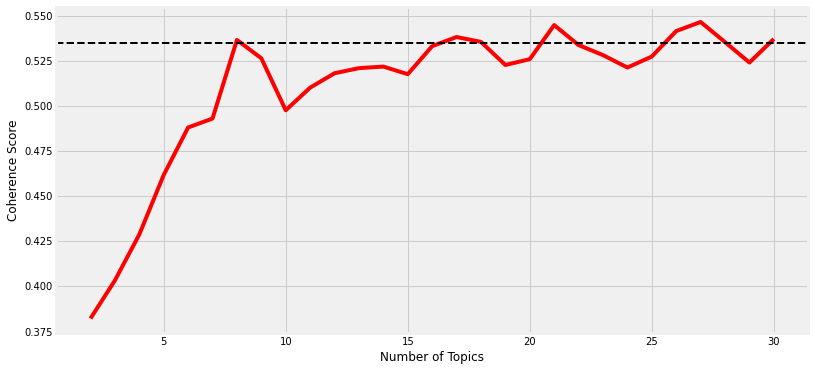

time: 254 ms (started: 2021-09-20 20:49:22 +00:00)


In [29]:
x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

It looks like the score starts increasing rapidly when the number of topics is five and gradually starts plateauing at 19 or 20. We choose the optimal number of topics as 20, based on our intuition.

In [30]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

time: 27 ms (started: 2021-09-20 20:49:22 +00:00)


Let’s view all the 20 topics generated by our selected best model.

In [31]:
topics = [[(term, round(wt, 3)) for term, wt in best_lda_model.show_topic(n, topn=20)] for n in range(0, best_lda_model.num_topics)]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic1,"rule, representation, task, target, generalization, theory, concept, human, learned, role, knowledge, connectionist, hypothesis, note, category, subject, level, instance, learn, pair"
Topic2,"control, trajectory, position, motor, movement, controller, hand, robot, change, dynamic, forward, target, feedback, arm, task, environment, behavior, adaptive, mapping, field"
Topic3,"state, dynamic, neuron, recurrent, equation, attractor, fixed_point, sequence, transition, phase, neural, stable, delay, stability, behavior, continuous, hopfield, matrix, dynamical, nonlinear"
Topic4,"bound, class, theorem, approximation, threshold, proof, xi, loss, size, complexity, linear, probability, polynomial, defined, theory, definition, bounded, assume, define, constant"
Topic5,"cell, neuron, activity, response, synaptic, pattern, stimulus, cortical, firing, cortex, connection, layer, et_al, effect, simulation, synapsis, mechanism, brain, neural, property"
Topic6,"state, action, step, policy, reinforcement_learning, optimal, control, environment, task, reward, td, agent, trial, goal, rl, current, reinforcement, machine, transition, update"
Topic7,"search, experiment, feature, application, user, table, query, technique, task, strategy, rate, run, average, test, block, program, evaluation, random, high, active"
Topic8,"feature, object, cluster, distance, image, map, view, structure, clustering, transformation, part, vector, recognition, representation, matching, level, dimension, match, prototype, rotation"
Topic9,"training, tree, test, training_set, expert, machine, size, generalization, trained, ensemble, digit, test_set, pruning, et_al, margin, table, classification, complexity, step, experiment"
Topic10,"noise, rate, equation, optimal, average, gradient, convergence, curve, distribution, theory, solution, line, constant, limit, vector, variance, eq, stochastic, teacher, generalization_error"


time: 31 ms (started: 2021-09-20 20:49:22 +00:00)


## Interpreting Topic Model Results
An interesting point to remember is, given a corpus of documents (in the form of features, e.g., Bag of Words) and a trained topic model, you can predict the distribution of topics in each document (research paper in this case):

In [ ]:
tm_results = best_lda_model[bow_corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

In [35]:
pd.set_option('display.max_colwidth', 300)
corpus_topic_df.head()

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
0,0,4,34.32,"bound, class, theorem, approximation, threshold, proof, xi, loss, size, complexity, linear, probability, polynomial, defined, theory, definition, bounded, assume, define, constant","1 \nCONNECTIVITY VERSUS ENTROPY \nYaser S. Abu-Mostafa \nCalifornia Institute of Technology \nPasadena, CA 91125 \nABSTRACT \nHow does the connectivity of a neural network (number of synapses per \nneuron) relate to the complexity of the problems it can handle (measured by \nthe entropy)? Switch..."
1,1,3,27.21,"state, dynamic, neuron, recurrent, equation, attractor, fixed_point, sequence, transition, phase, neural, stable, delay, stability, behavior, continuous, hopfield, matrix, dynamical, nonlinear",22 \nLEARNING ON A GENERAL NETWORK \nAmir F. Atiya \nDepartment of Electrical Engineering \nCalifornia Institute of Technology \nCa 91125 \nAbstract \nThis paper generalizes the backpropagation method to a general network containing feed- \nback connections. The network model considered consists...
2,2,3,16.45,"state, dynamic, neuron, recurrent, equation, attractor, fixed_point, sequence, transition, phase, neural, stable, delay, stability, behavior, continuous, hopfield, matrix, dynamical, nonlinear","31 \nAN ARTIFICIAL NEURAL NETWORK FOR SPATIO- \nTEMPORAL BIPOLAR PATTERNS: APPLICATION TO \nPHONEME CLASSIFICATION \nToshiteru Homma \nLes E. Atlas \nRobert J. Marks H \nInteractive Systems Design Laboratory \nDepartment of Electrical Engineering, FT-10 \nUniversity of Washington \nSeattle, Wash..."
3,3,4,37.46,"bound, class, theorem, approximation, threshold, proof, xi, loss, size, complexity, linear, probability, polynomial, defined, theory, definition, bounded, assume, define, constant","41 \nON PROPERTIES OF NETWORKS \nOF NEURON-LIKE ELEMENTS \nPierre Baldi* and Santosh S. Venlmtesh I \n15 December 1987 \nAbstract \nThe complexity and computational capacity of multi-layered, feedforward \nneural networks is examined. Neural networks for special purpose (structured) \nfunctions ..."
4,4,14,20.72,"unit, layer, net, hidden_unit, training, architecture, activation, node, pattern, back_propagation, hidden_layer, connection, trained, task, hidden, backpropagation, learn, simulation, step, epoch","52 \nSupervised Learning of Probability Distributions \nby Neural Networks \nEric B. Baum \nJet Propulsion Laboratory, Pasadena CA 91109 \nFrank Wilczek \nDepartment of Physics,Harvard University, Cambridge MA 02138 \nAbstract: \nWe propose that the back propagation algorithm for super- \nvised..."


time: 17.3 ms (started: 2021-09-20 20:54:09 +00:00)


Let’s now take a look at various ways we can transform these results and extract meaningful insights from our research papers and their topics.

### Dominant Topics Distribution across Corpus
Mainly we want to determine the total number of papers and the total percentage of papers where each of the 20 topics was the most dominant.

In [ ]:
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg(Doc_count=('Dominant Topic','count')).reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['Doc_count'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
topic_stats_df

In [59]:
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg(Doc_count=('Dominant Topic','count')).reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['Doc_count'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
topic_stats_df

,Dominant Topic,Doc_count,% Total Docs,Topic Desc
0,1,57,3.28,"rule, representation, task, target, generalization, theory, concept, human, learned, role, knowledge, connectionist, hypothesis, note, category, subject, level, instance, learn, pair"
1,2,68,3.91,"control, trajectory, position, motor, movement, controller, hand, robot, change, dynamic, forward, target, feedback, arm, task, environment, behavior, adaptive, mapping, field"
2,3,78,4.48,"state, dynamic, neuron, recurrent, equation, attractor, fixed_point, sequence, transition, phase, neural, stable, delay, stability, behavior, continuous, hopfield, matrix, dynamical, nonlinear"
3,4,120,6.90,"bound, class, theorem, approximation, threshold, proof, xi, loss, size, complexity, linear, probability, polynomial, defined, theory, definition, bounded, assume, define, constant"
4,5,168,9.66,"cell, neuron, activity, response, synaptic, pattern, stimulus, cortical, firing, cortex, connection, layer, et_al, effect, simulation, synapsis, mechanism, brain, neural, property"
5,6,94,5.40,"state, action, step, policy, reinforcement_learning, optimal, control, environment, task, reward, td, agent, trial, goal, rl, current, reinforcement, machine, transition, update"
6,7,66,3.79,"search, experiment, feature, application, user, table, query, technique, task, strategy, rate, run, average, test, block, program, evaluation, random, high, active"
7,8,69,3.97,"feature, object, cluster, distance, image, map, view, structure, clustering, transformation, part, vector, recognition, representation, matching, level, dimension, match, prototype, rotation"
8,9,74,4.25,"training, tree, test, training_set, expert, machine, size, generalization, trained, ensemble, digit, test_set, pruning, et_al, margin, table, classification, complexity, step, experiment"
9,10,89,5.11,"noise, rate, equation, optimal, average, gradient, convergence, curve, distribution, theory, solution, line, constant, limit, vector, variance, eq, stochastic, teacher, generalization_error"


time: 34.3 ms (started: 2021-09-20 21:24:03 +00:00)


The results show us that most of the papers cover topics of probabilistic models and Bayesian modeling (Topic #8), followed by papers covering modeling and simulating how the brain works with neurons, cells, stimulus, and connections (Topic #10). Even Topic #14, covering reinforcement learning and robotics, has almost 6.32% representation of the total number of papers. This tells us it’s not a new thing and people have been researching it for decades!

### Dominant Topics in Specific Research Papers
Another interesting perspective is to select specific papers, view the most dominant topic in each of those papers, and see if that makes sense.

In [37]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin([681, 9, 392, 1622, 17, 
                        906, 996, 503, 13, 733])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
9,9,19,37.32,"signal, frequency, response, spike, channel, stimulus, temporal, noise, filter, rate, amplitude, event, auditory, sound, phase, change, threshold, correlation, effect, neural","103 \nNEURAL NETWORKS FOR TEMPLATE MATCHING: \nAPPLICATION TO REAL-TIME CLASSIFICATION \nOF THE ACTION POTENTIALS OF REAL NEURONS \nYiu-fai Wong, Jashojiban Banik]. and James M. Bower$ \n]'Divisi..."
13,13,20,31.53,"word, recognition, sequence, speech, training, context, character, hmm, letter, speaker, frame, language, state, string, speech_recognition, trained, phoneme, feature, segmentation, window","144 \nSPEECH RECOGNITION EXPERIMENTS \nWITH PERCEPTRONS \nD. J. Burr \nBell Communications Research \nMorristown, NJ 07960 \nABSTRACT \nArtificial neural networks (ANNs) are capable of accurate re..."
17,17,4,17.00,"bound, class, theorem, approximation, threshold, proof, xi, loss, size, complexity, linear, probability, polynomial, defined, theory, definition, bounded, assume, define, constant","219 \nNetwork Generality, Training Required, \nand Precision Required \nJohn S. Denker and Ben S. Wittner \nAT&T Bell Laboratories \nHolmdel, New Jersey 07733 \nKeep your hand on your wa]let. \n--..."
392,392,7,35.95,"search, experiment, feature, application, user, table, query, technique, task, strategy, rate, run, average, test, block, program, evaluation, random, high, active","Using Genetic Algorithms to Improve \nPattern Classification Performance \nEric I. Chang and Richard P. Lippmann \nLincoln Laboratory, MIT \nLexington, MA 02173-9108 \nAbstract \nGenetic algorithm..."
503,503,19,39.54,"signal, frequency, response, spike, channel, stimulus, temporal, noise, filter, rate, amplitude, event, auditory, sound, phase, change, threshold, correlation, effect, neural",Neural Network Analysis of Event Related \nPotentials and Electroencephalogram Predicts \nVigilance \nRita Venturini \nWilliam W. Lytton \nTerrence J. Sejnowski \nComputational Neurobiology Labora...
681,681,2,33.20,"control, trajectory, position, motor, movement, controller, hand, robot, change, dynamic, forward, target, feedback, arm, task, environment, behavior, adaptive, mapping, field","Mapping Between Neural and Physical \nActivities of the Lobster Gastric Mill \nKenji Doya \nMary E.T. Boyle \nAllen I. Selverston \nDepartment of Biology \nUniversity of California, San Diego \nLa..."
733,733,9,44.92,"training, tree, test, training_set, expert, machine, size, generalization, trained, ensemble, digit, test_set, pruning, et_al, margin, table, classification, complexity, step, experiment",Optimal Brain Surgeon: \nExtensions and performance comparisons \nBabak Hassibi* \nDavid G. Stork \nGregory Wolff \nTakahiro Watanabe \nRicoh California Research Center \n2882 Sand Hill Road Suite...
906,906,1,28.63,"rule, representation, task, target, generalization, theory, concept, human, learned, role, knowledge, connectionist, hypothesis, note, category, subject, level, instance, learn, pair","Extracting Rules from Artificial Neural Networks \nwith Distributed Representations \nSebastian Thrun \nUniversity of Bonn \nDepartment of Computer Science III \nR6merstr. 164, D-53117 Bonn, Germa..."
996,996,2,26.32,"control, trajectory, position, motor, movement, controller, hand, robot, change, dynamic, forward, target, feedback, arm, task, environment, behavior, adaptive, mapping, field",A Dynamical Model of Context Dependencies for the \nVestibulo-Ocular Reflex \nO!ivier J.M.D. Coenen* \nTerrence J. Sejnowskit \nComputational Neurobiology Laboratory \nHoward Hughes Medical Instit...
1622,1622,4,33.21,"bound, class, theorem, approximation, threshold, proof, xi, loss, size, complexity, linear, probability, polynomial, defined, theory, definition, bounded, assume, define, constant","Model Selection for Support Vector Machines \nOlivier Chapelle*,t, Vladimir Vapnik* \n* AT&T Research Labs, Red Bank, NJ \nt LIP6, Paris, France \n{ chapelle, vlad} @re

time: 29.5 ms (started: 2021-09-20 20:57:28 +00:00)


Based on the results, we can see that they make perfect sense! Papers on reinforcement learning, signal processing, gaussian mixture models, processor simulations, word recognitions, and many more have corresponding relevant topics as the most dominant topics. This tells us that our topic model is working well.


### Relevant Research Papers per Topic based on Dominance
A better way of representation is to try to retrieve the corresponding research paper that has the highest representation for each of the 20 topics.

In [38]:
corpus_topic_df.groupby('Dominant Topic').apply(
    lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,678,1,52.78,"rule, representation, task, target, generalization, theory, concept, human, learned, role, knowledge, connectionist, hypothesis, note, category, subject, level, instance, learn, pair","A Knowledge-Based Model of Geometry Learning \nGeoffrey Towell \nSiemens Corporate Research \n755 College Road East \nPrinceton, NJ 08540 \ntoweli @ learning. siemens. com \nRichard Lehrer \nEduca..."
2,343,2,74.99,"control, trajectory, position, motor, movement, controller, hand, robot, change, dynamic, forward, target, feedback, arm, task, environment, behavior, adaptive, mapping, field",Learning Trajectory and Force Control \nof an Artificial Muscle Arm \nby Parallel-hierarchical Neural Network Model \nMasazumi Katayama Mitsuo Kawato \nCognitive Processes Department \nATR Auditor...
3,139,3,63.25,"state, dynamic, neuron, recurrent, equation, attractor, fixed_point, sequence, transition, phase, neural, stable, delay, stability, behavior, continuous, hopfield, matrix, dynamical, nonlinear","568 \nDYNAMICS OF ANALOG NEURAL \nNETWORKS WITH TIME DELAY \nC.M. Marcus and R.M. Westervelt \nDivision of Applied Sciences and Department of Physics \nHarvard University, Cambridge Massachusetts ..."
4,534,4,80.39,"bound, class, theorem, approximation, threshold, proof, xi, loss, size, complexity, linear, probability, polynomial, defined, theory, definition, bounded, assume, define, constant","Polynomial Uniform Convergence of \nRelative Frequencies to Probabilities \nAlberto Bertoni, Paola Campadelll;' Anna Morpurgo, Sandra Panlzza \nDipartimento di Scienze dell'Informazione \nUniversi..."
5,438,5,78.52,"cell, neuron, activity, response, synaptic, pattern, stimulus, cortical, firing, cortex, connection, layer, et_al, effect, simulation, synapsis, mechanism, brain, neural, property","Retinogeniculate Development: \nThe Role of Competition and Correlated Retinal \nActivity \nRon Keesing* \nDept. of Physiology \nU.C. San Francisco \nSan Francisco, CA 94143 \nkeesing@phy.ucsf.edu..."
6,1578,6,73.92,"state, action, step, policy, reinforcement_learning, optimal, control, environment, task, reward, td, agent, trial, goal, rl, current, reinforcement, machine, transition, update",The effect of eligibility traces on finding optimal memoryless \npolicies in partially observable Markov decision processes \nJohn Loch \nDepartment of Computer Science \nUniversity of Colorado \n...
7,706,7,61.12,"search, experiment, feature, application, user, table, query, technique, task, strategy, rate, run, average, test, block, program, evaluation, random, high, active","When Will a Genetic Algorithm \nOutperform Hill Climbing? \nMelanie Mitchell \nSanta Fe Institute \n1660 Old Pecos Trail, Suite A \nSanta Fe, NM 87501 \nJohn H. Holland \nDept. of Psychology \nUni..."
8,213,8,51.13,"feature, object, cluster, distance, image, map, view, structure, clustering, transformation, part, vector, recognition, representation, matching, level, dimension, match, prototype, rotation","266 Zemel, Mozer and Hinton \nTRAFFIC: Recognizing Objects Using \nHierarchical Reference Frame Transformations \nRichard S. Zemel \nComputer Science Dept. \nUniversity of Toronto \nToronto, ONT M..."
9,1049,9,68.71,"training, tree, test, training_set, expert, machine, size, generalization, trained, ensemble, digit, test_set, pruning, et_al, margin, table, classification, complexity, step, experiment","Boosting Decision Trees \nHarris Drucker \nAT&T Bell Laboratories \nHolmdel, New Jersey 07733 \nCorinna Cortes \nAT&T Bell Laboratories \nMurray Hill, New Jersey 07974 \nAbstract \nA new boosting ..."


time: 50.5 ms (started: 2021-09-20 20:57:35 +00:00)


It looks like our model has captured the relevant latent patterns and themes in our corpus.

## Predicting Topics for New Research Papers
Even though topic models are unsupervised models, we can estimate or predict potential topics for new documents based on what it has learned previously on the so-called “training” corpus. 

### Load some testing samples
For testing our model, let's load some recent papers from the NIPS 16 conference proceedings.

In [39]:
TEST_DATA_PATH = 'datasets/test_data/'
file_names = os.listdir(TEST_DATA_PATH) 
new_papers = []
for file_name in file_names:
  with open(TEST_DATA_PATH + file_name, 
            encoding='utf-8', errors='ignore', mode='r+') as f:
    data = f.read() 
    new_papers.append(data)
len(new_papers)

4

time: 1.93 s (started: 2021-09-20 20:57:44 +00:00)


### Build a text wrangling and feature engineering pipeline
These steps should match the same steps we followed when training our topic model.


In [40]:
def text_preprocessing_pipeline(documents, normalize_corpus, bigram_model):
    norm_docs = normalize_corpus(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, 
                                              normalize_corpus=normalize_corpus, 
                                              bigram_model=bigram_model)
norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, 
                                          dictionary=dictionary)

time: 168 ms (started: 2021-09-20 20:57:50 +00:00)


### Extract the top n topics from a paper

In [41]:
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt, 3)) for topic, wt in sorted(topic_predictions[i], key=lambda row: -row[1])[:topn]] for i in range(len(topic_predictions))]
    return best_topics

# get the top two topics for each research paper 
topic_preds = get_topic_predictions(topic_model=best_lda_model, corpus=norm_bow_features, topn=2)
topic_preds


[[(16, 0.247), (3, 0.218)],
 [(5, 0.438), (3, 0.228)],
 [(12, 0.207), (4, 0.123)],
 [(19, 0.295), (7, 0.129)]]

time: 1.78 s (started: 2021-09-20 20:57:56 +00:00)


We get the top two topics for each research paper because a paper or document can always be a mixture of multiple topics. Let’s view the results for each paper in an easy-to-understand format.

In [43]:
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in item] for item in topic_preds]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Contribution %'] = [topic_wt for topic_list in [[round(wt*100, 2) for topic_num, wt in item] for item in topic_preds] for topic_wt in topic_list]
results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic'] for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]
results_df

,Dominant Topics,Contribution %,Topic Desc,Paper Desc
Papers,,,,
1,17,24.7,"distribution, probability, prior, variable, mixture, density, gaussian, bayesian, estimate, approximation, likelihood, log, sample, em, posterior, step, probabilistic, estimation, component, variance","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer S..."
1,4,21.8,"bound, class, theorem, approximation, threshold, proof, xi, loss, size, complexity, linear, probability, polynomial, defined, theory, definition, bounded, assume, define, constant","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer S..."
2,6,43.8,"state, action, step, policy, reinforcement_learning, optimal, control, environment, task, reward, td, agent, trial, goal, rl, current, reinforcement, machine, transition, update","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York,..."
2,4,22.8,"bound, class, theorem, approximation, threshold, proof, xi, loss, size, complexity, linear, probability, polynomial, defined, theory, definition, bounded, assume, define, constant","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York,..."
3,13,20.7,"image, visual, motion, pixel, direction, face, location, spatial, field, orientation, response, local, receptive_field, region, contour, edge, filter, processing, velocity, object","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\..."
3,5,12.3,"cell, neuron, activity, response, synaptic, pattern, stimulus, cortical, firing, cortex, connection, layer, et_al, effect, simulation, synapsis, mechanism, brain, neural, property","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\..."
4,20,29.5,"word, recognition, sequence, speech, training, context, character, hmm, letter, speaker, frame, language, state, string, speech_recognition, trained, phoneme, feature, segmentation, window","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute..."
4,8,12.9,"feature, object, cluster, distance, image, map, view, structure, clustering, transformation, part, vector, recognition, representation, matching, level, dimension, match, prototype, rotation","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute..."


time: 33.3 ms (started: 2021-09-20 20:58:15 +00:00)


The results likely confirm our model has done an excellent job!